In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Load the data (Assuming you saved the text as a CSV)
df = pd.read_excel('/content/Jumbo & Company_ Attach % .xls')

# We need to reorder them for time-series analysis.
month_order = ['Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Melt the dataframe to make it "Long Format" (better for analysis)
df_melted = df.melt(id_vars=['Branch', 'Store_Name'],
                    var_name='Month',
                    value_name='Attach_Rate')

# Convert Month to categorical with order
df_melted['Month'] = pd.Categorical(df_melted['Month'], categories=month_order, ordered=True)
df_melted = df_melted.sort_values(['Branch', 'Store_Name', 'Month'])

# Handle missing values (fill with 0)
df_melted['Attach_Rate'] = df_melted['Attach_Rate'].fillna(0)

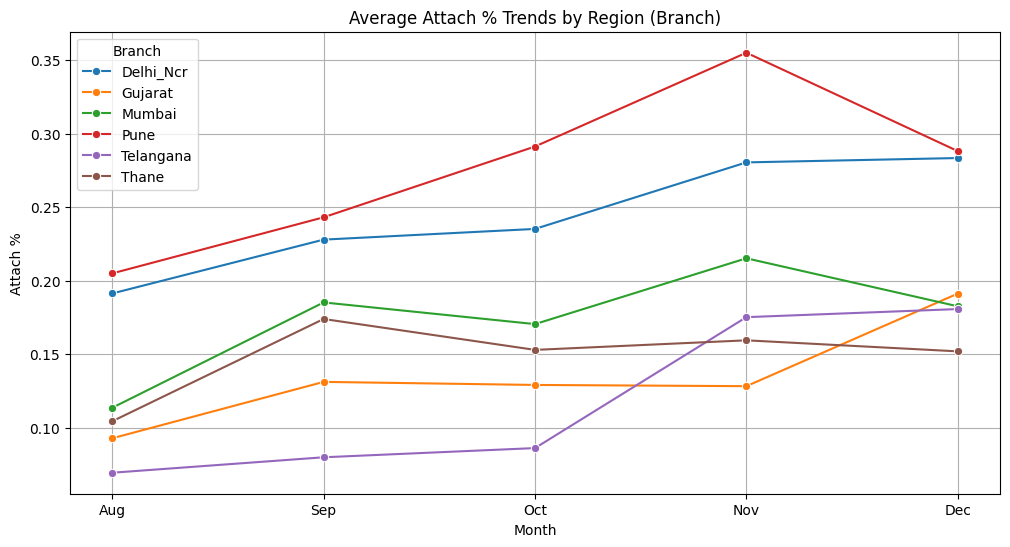

In [2]:
# Aggregate by Branch and Month
branch_performance = df_melted.groupby(['Branch', 'Month'])['Attach_Rate'].mean().reset_index()

# Visualization: Branch Performance Trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=branch_performance, x='Month', y='Attach_Rate', hue='Branch', marker='o')
plt.title('Average Attach % Trends by Region (Branch)')
plt.ylabel('Attach %')
plt.grid(True)
plt.show()

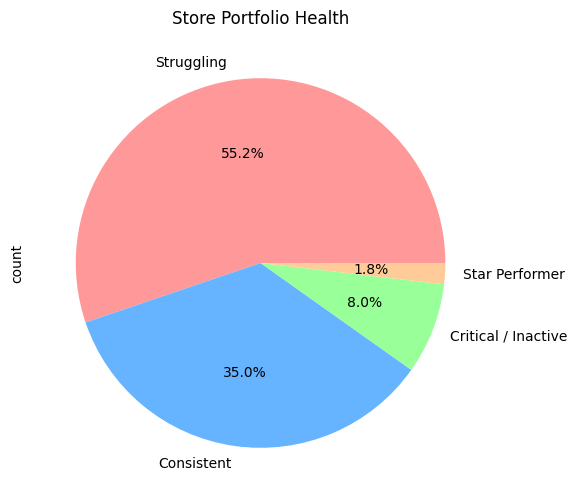

In [3]:
# Calculate average performance per store
store_stats = df_melted.groupby('Store_Name')['Attach_Rate'].agg(['mean', 'std']).reset_index()

# Define Logic for Categorization
def categorize_store(row):
    if row['mean'] > 0.40:
        return 'Star Performer'
    elif row['mean'] > 0.20:
        return 'Consistent'
    elif row['mean'] > 0.05:
        return 'Struggling'
    else:
        return 'Critical / Inactive'

store_stats['Category'] = store_stats.apply(categorize_store, axis=1)

# Visualization: Pie chart of Store Categories
plt.figure(figsize=(6, 6))
store_stats['Category'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Store Portfolio Health')
plt.show()

In [4]:
# Weighted prediction

def predict_january(row):
    # Weighted average giving more importance to recent month
    dec = row['Dec'] if not pd.isna(row['Dec']) else 0
    nov = row['Nov'] if not pd.isna(row['Nov']) else 0
    oct_val = row['Oct'] if not pd.isna(row['Oct']) else 0

    prediction = (dec * 0.5) + (nov * 0.3) + (oct_val * 0.2) # Simple logic: 50% Dec + 30% Nov + 20% Oct
    return round(prediction, 3)

df["Jan_prediction_weighted"] = df.apply(predict_january, axis=1)

print(df[['Branch', 'Store_Name', 'Jan_prediction_weighted']].sort_values(by='Jan_prediction_weighted', ascending=False).head(10))

        Branch            Store_Name  Jan_prediction_weighted
29        Pune     Pune(Dange Chowk)                    0.612
10   Delhi_Ncr      Delhi(Hauz Khas)                    0.599
116  Delhi_Ncr  Haryana(M G Road) Br                    0.553
91   Delhi_Ncr         Delhi(Narela)                    0.548
59   Telangana              Ts(Bhel)                    0.498
69        Pune        Pune(Hadapsar)                    0.493
64        Pune        Pune(Kondhawa)                    0.493
81   Delhi_Ncr     Delhi(Budh Vihar)                    0.447
21   Delhi_Ncr  Haryana(Mewla M.) Br                    0.446
12   Telangana          Ts(Kondapur)                    0.432


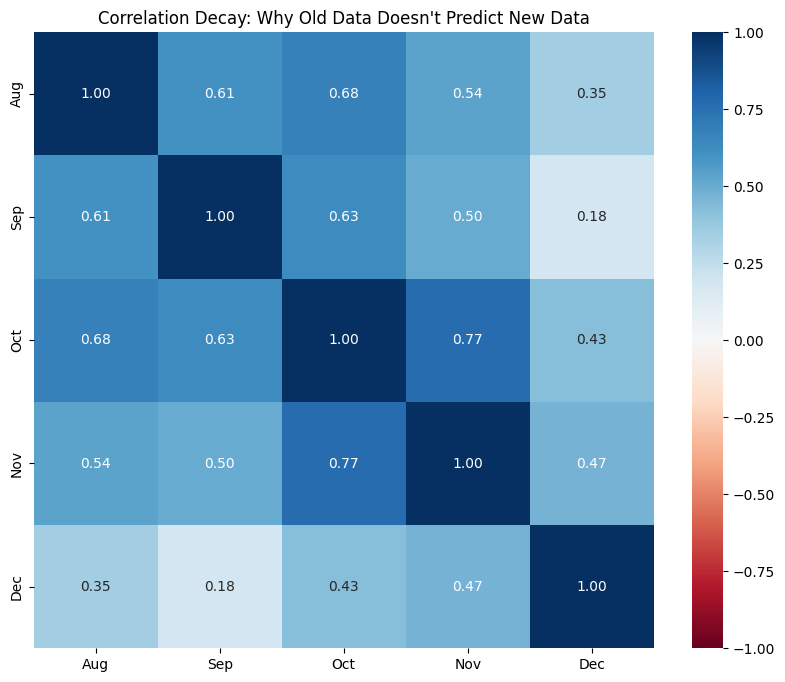

In [5]:
# Prepare Data for Correlation Analysis

cols_chronological = ['Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_corr = df[cols_chronological].corr()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Decay: Why Old Data Doesn\'t Predict New Data')
plt.show()

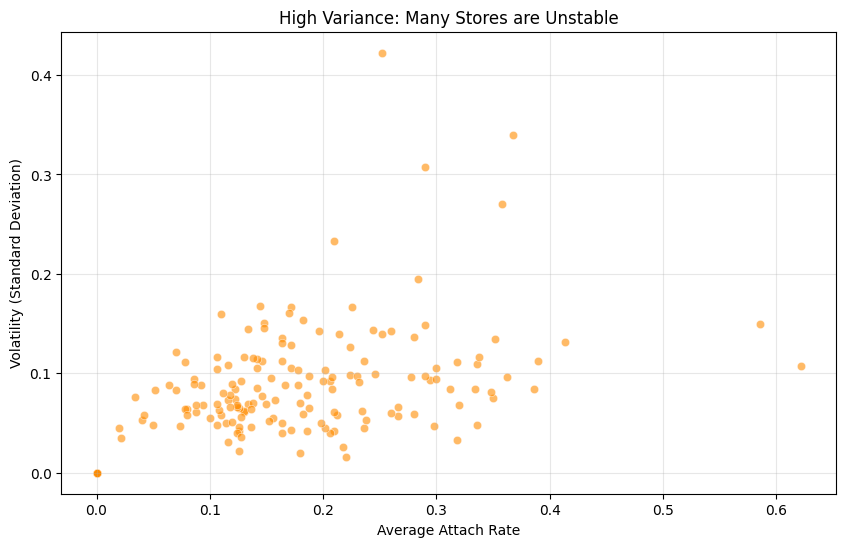

In [6]:
# Volatility Analysis

df['Mean_Attach'] = df[cols_chronological].mean(axis=1)
df['Std_Attach'] = df[cols_chronological].std(axis=1)

# Volatility Scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Mean_Attach', y='Std_Attach', alpha=0.6, color='darkorange')
plt.title('High Variance: Many Stores are Unstable')
plt.xlabel('Average Attach Rate')
plt.ylabel('Volatility (Standard Deviation)')
plt.grid(True, alpha=0.3)
plt.show()

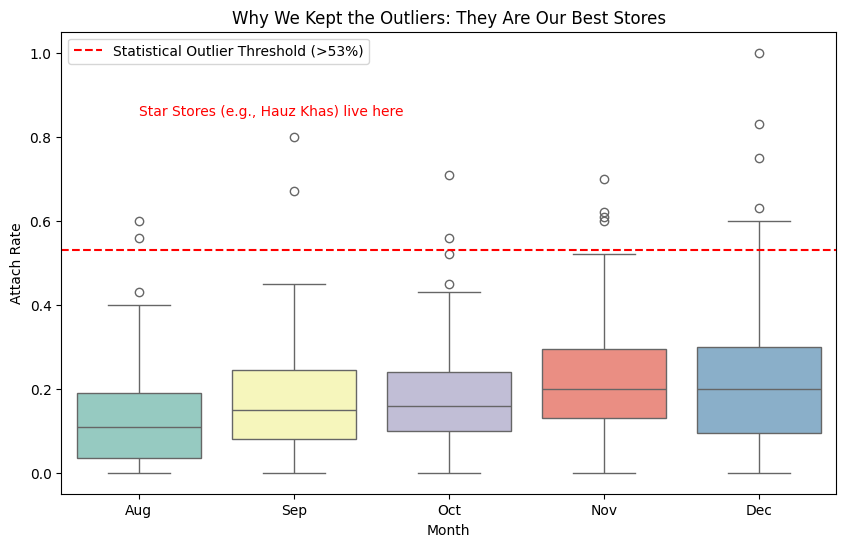

In [7]:
plt.figure(figsize=(10, 6))

# Create a Boxplot to visualize the spread
sns.boxplot(x='Month', y='Attach_Rate', data=df_melted, palette="Set3")

# Highlight the "Star Performers" that look like outliers
plt.title('Why We Kept the Outliers: They Are Our Best Stores')
plt.ylabel('Attach Rate')
plt.axhline(y=0.53, color='r', linestyle='--', label='Statistical Outlier Threshold (>53%)')
plt.text(0, 0.85, 'Star Stores (e.g., Hauz Khas) live here', color='red', fontsize=10)
plt.legend()
plt.show()

In [8]:
# Logic to flag "Inconsistent" stores
def get_january_prediction(row):
    values = [row['Aug'], row['Sep'], row['Oct'], row['Nov'], row['Dec']]
    std_dev = np.std(values)
    mean_val = np.mean(values)

    # Define "Inconsistency Rule" : If Std Dev > 0.20 (Absolute Volatility) OR CV > 0.7 (Relative Volatility)
    is_inconsistent = (std_dev > 0.20) or (mean_val > 0.05 and (std_dev/mean_val) > 0.7)

    # Treat Inconsistent Points as Outliers (Smoothing)
    if is_inconsistent:
        median_val = np.median(values)
        # Replace any month that deviates > 1.5x Std Dev from the Median
        smoothed_values = []
        for v in values:
            if abs(v - median_val) > (1.5 * std_dev):
                smoothed_values.append(median_val) # Cap the outlier
            else:
                smoothed_values.append(v)

        # Predict using Smoothed Data (Weights: 0.5, 0.3, 0.2)
        prediction = (smoothed_values[4] * 0.5) + (smoothed_values[3] * 0.3) + (smoothed_values[2] * 0.2)
        return round(prediction, 3), "Flagged & Smoothed"

    else:
        # 3. For Consistent Stores, trust the trend (Weights: 0.5, 0.3, 0.2)
        prediction = (row['Dec']*0.5) + (row['Nov']*0.3) + (row['Oct']*0.2)
        return round(prediction, 3), "Stable"

# Apply to dataframe
df[['Jan_Prediction', 'Status']] = df.apply(
    lambda x: pd.Series(get_january_prediction(x)), axis=1
)

# Show the impact
print("Impact of Outlier Smoothing:")
print(df[df['Status'] == 'Flagged & Smoothed'][['Store_Name', 'Dec', 'Jan_Prediction']].head(5))

Impact of Outlier Smoothing:
                Store_Name   Dec  Jan_Prediction
18   Ts(Vivekananda Nagar)  0.31           0.080
23  Haryana(New Faridabad)  0.36           0.150
29       Pune(Dange Chowk)  0.58           0.612
48       Ts(Jubilee Hills)  0.00           0.053
59                Ts(Bhel)  0.83           0.168


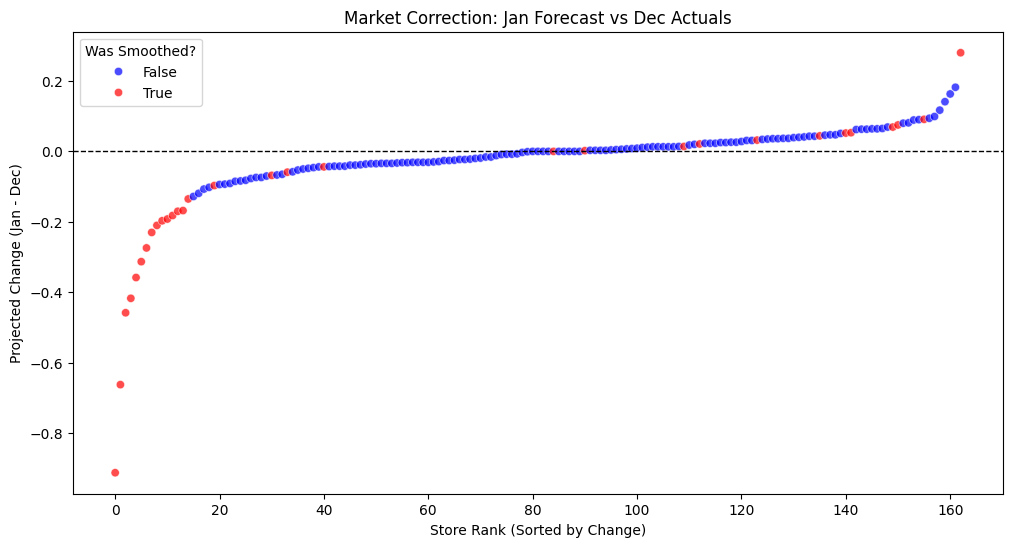

In [9]:
df['Is_Inconsistent'] = df['Status'] == 'Flagged & Smoothed'

# Calculate the difference (Jan Forecast - Dec Actual)
df['Diff_Jan_Dec'] = df['Jan_Prediction'] - df['Dec']

df_sorted = df.sort_values(by='Diff_Jan_Dec').reset_index(drop=True)

# Prediction after smoothing
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_sorted,
    x=df_sorted.index,
    y='Diff_Jan_Dec',
    hue='Is_Inconsistent',
    palette={True: 'red', False: 'blue'}, # Red for inconsistent/smoothed stores
    alpha=0.7
)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Market Correction: Jan Forecast vs Dec Actuals')
plt.xlabel('Store Rank (Sorted by Change)')
plt.ylabel('Projected Change (Jan - Dec)')
plt.legend(title='Was Smoothed?')
plt.show()